# Setup

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import cloudpickle
import colour 
from colour.plotting import *

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# Get original experiments

## setup

In [3]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


In [4]:
import numpy as np 

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 441)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 800)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 441)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 800)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

def smooth_spectrum(x, y, window=4):
    y = np.array(y)
    y_smooth = np.zeros_like(y)
    for i in range(len(y)):
        if i < window:
            y_smooth[i] = np.mean(y[:i+window])
        elif i > len(y) - window:
            y_smooth[i] = np.mean(y[i-window:])
        else:
            y_smooth[i] = np.mean(y[i-window:i+window])
    return x, y_smooth.tolist()

## Extend the experiment df with the experiment processed results

In [5]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            y = [(i-min(y)) for i in y]
            x, y = smooth_spectrum(x, y)
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            x, y = smooth_spectrum(x, y)
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
            abs_s = df[df['nm'] == 430][' A'].values[0]
            fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
            fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
            qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2
        else:
            print(f"File not available: Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = -1

        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    'QY': [qy],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm]
                                    }) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
# processed_df.to_csv('Data/processed_data.csv', index=False)

File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-10.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/0-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/50-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-60.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-1-180.csv
File not available: Data/absorbance_data/8_NPL-13_(3-8-23)/25-5-180.csv


## Create dataset with experiments and entire espectra points

In [6]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/fl_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')

new_columns = ['Wavelength(nm)', 'Absorbance', 'Absorbance_norm']
with open('Data/abs_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                x, y = smooth_spectrum(x, y)
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')
            else:
                pass

## Process all procedures (original and new ones)

In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
# df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-3]

features, labels

(Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
        'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
        'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
       dtype='object'),
 Index(['Peak1', 'Peak2', 'Area1', 'Area2', 'Pre-QY', 'QY', 'QY_peak1',
        'QY_peak2', 'Fl_Wavelengths', 'Fluorescence', 'Fluorescence_norm',
        'Abs_Wavelengths', 'Absorbance', 'CIE_x', 'CIE_y'],
       dtype='object'))

In [28]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512 nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

# prompts = []
# labels_peak1 = []
# labels_peak2 = []
# labels_auc1 = []
# labels_auc2 = []
# labels_qy   = []
# labels_f    = []
# for i, r in df.iterrows():
#     if r['QY']*r['Area2'] < 0.0:
#         continue
#     s = r[features].to_dict()
#     prompts.append(prompt_template.format(**s))
#     labels_peak1.append(r['Peak1'])
#     labels_peak2.append(r['Peak2'])
#     labels_auc1.append(r['Area1'])
#     labels_auc2.append(r['Area2'])
#     labels_qy.append(r['QY'])
#     labels_f.append(r['QY']*r['Area2'])

df['Prompt'] = df.apply(lambda row: prompt_template.format(**row), axis=1)
df['f'] = df['QY'] * df['Area2']


In [ ]:
def process_input(fl_data, abs_data, is_val_data = False):
    # Process fluorescence data
    lines = fl_data.readlines()
    x = []
    y = []
    for line in lines:
        x.append(float(line.split()[0]))
        y.append(float(line.split()[1]))
    x, y = smooth_spectrum(x, y)
    fl_int_norm = [yi/max(y) for yi in y]
    fl_auc_total = get_area_under_peaks(x, y)
    peaks, areas = process_spectrum(x, y, norm_area=fl_auc_total)
    fl_wvl, fl_int = x[:], y[:]

    # Process absorbance data
    df = pd.read_csv(abs_data)
    df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
    x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
    x, y = smooth_spectrum(x, y)
    abs_int_norm = [yi/max(y) for yi in y]
    abs_auc_total = get_area_under_peaks(x, y)
    abs_wvl, abs_int = x[:], y[:]
    # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa's spreadsheet
    abs_s = df[df['nm'] == 430][' A'].values[0]
    fl_r, abs_r, n_r = 8272505, 0.129734, 1.3611
    if is_val_data:
        fl_r, abs_r, n_r = 9453221.02, 0.039083, 1.3611
    fl_s, abs_s, n_s = fl_auc_total, abs_s, 1.375
    qy = 0.53 * (fl_auc_total/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2

    #plot the fluoresdcence spectra and the absorbanc spectra
    # fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    # ax[0].plot(fl_wvl, fl_int, label='Fluorescence')
    # ax[0].set_title('Fluorescence Spectrum')
    # ax[0].set_xlabel('Wavelength (nm)')
    # ax[0].set_ylabel('Intensity')
    # ax[0].legend()
    # ax[1].plot(abs_wvl, abs_int, label='Absorbance')
    # ax[1].set_title('Absorbance Spectrum')
    # ax[1].set_xlabel('Wavelength (nm)')
    # ax[1].set_ylabel('Intensity')
    # ax[1].legend()
    # plt.tight_layout()
    # plt.show()

    return peaks[0], peaks[1], areas[0], areas[1], qy, qy*areas[1], (fl_wvl, fl_int, fl_int_norm), (abs_wvl, abs_int, abs_int_norm)

procedures = df.copy()

BO_NLP = {
    "ICL1-R1" : "Stock nanoplatelets have dimensions 46.3494 nm by 8.095 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 5.0 % Ag doping requires 45.3 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL1-R2" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 0.25 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL1-R3" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10 mL of MeOH and 4 mL of water. 0.25 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL1-R4" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL1-R5" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512 nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.2 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    # "M2-R1" : "", # <- Was not performed due to lack of material with the proposed dimensions #
    "ICL2-R2" : "Stock nanoplatelets have dimensions 46.3494 nm by 8.0954 nm (375.21nm2) and the optical density of 100x hexanes dilution of stock is 0.31% recorded at 511 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 13.372 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL2-R3" : "Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm (274.8nm2) and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 510 nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL2-R4" : "Stock nanoplatelets have dimensions 36.9 nm by 7.44 nm (274.8nm2) and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 510 nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 5.0 % Ag doping requires 11.8 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL2-R5" : "Stock nanoplatelets have dimensions 30.928 nm by 7.955 nm (246.042nm2) and the optical density of 100x hexanes dilution of stock is 0.3% recorded at 512 nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.5633 mL of MeOH and 2.2253 mL of water. 1.0 % Ag doping requires 4.2 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "ICL3-R1" : "Stock nanoplatelets have dimensions 19.835 nm by 14.762 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL3-R2" : "Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL3-R3" : "Stock nanoplatelets have dimensions 29.529 nm by 8.737 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL3-R4" : "Stock nanoplatelets have dimensions 19.835 nm by 14.762 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL3-R5" : "Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "ICL4-R1": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 14.000 mg of silver acetate in 85.589 mL of MeOH and 34.236 mL of water. 10.000 % Ag doping requires 344.528 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL4-R2": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 14.000 mg of silver acetate in 85.589 mL of MeOH and 34.236 mL of water. 5.000 % Ag doping requires 43.066 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL4-R3": "Stock nanoplatelets have dimensions 30.594 nm by 8.897 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 2.000 % Ag doping requires 9.388 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL4-R5": "Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 86.132 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "ICL5-R1": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 6.768 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R2": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 80.991 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes",
    "ICL5-R3": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 53.209 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R4": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 106.418 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R5": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 2.000 % Ag doping requires 3.780 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R6": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 27.072 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R7": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 14.000 mg of silver acetate in 9.985 mL of MeOH and 3.994 mL of water. 5.000 % Ag doping requires 3.104 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R8": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 10.000 % Ag doping requires 18.898 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL5-R9": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 2.000 % Ag doping requires 10.829 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #
    "ICL6-R1": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 6.768 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R2": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 80.991 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes",
    "ICL6-R3": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 53.209 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R4": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 5.000 % Ag doping requires 106.418 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R5": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 2.000 % Ag doping requires 3.780 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R6": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 27.072 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R7": "Stock nanoplatelets have dimensions 26.577 nm by 5.418 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 14.000 mg of silver acetate in 9.985 mL of MeOH and 3.994 mL of water. 5.000 % Ag doping requires 3.104 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R8": "Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 10.000 % Ag doping requires 18.898 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    "ICL6-R9": "Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 7.800 mg of silver acetate in 5.563 mL of MeOH and 2.225 mL of water. 2.000 % Ag doping requires 10.829 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.",
    #

    }

BO_NLP_pred = {
    "ICL1-R1" : 0.192,
    "ICL1-R2" : 0.08,
    "ICL1-R3" : 0.08,
    "ICL1-R4" : 0.04,
    "ICL1-R5" : 0.086,
    "ICL2-R1" : 0.202,
    "ICL2-R2" : 0.134,
    "ICL2-R3" : 0.150,
    "ICL2-R4" : 0.138,
    "ICL2-R5" : 0.158,
    "ICL3-R1" : 0.178,
    "ICL3-R2" : 0.170,
    "ICL3-R3" : 0.088,
    "ICL3-R4" : 0.072,
    "ICL3-R5" : 0.076,
    "ICL4-R1" : 0.094,
    "ICL4-R2" : 0.0744,
    "ICL4-R3" : 0.098,
    "ICL4-R5" : 0.144,
    "ICL5-R1" : 0.02024,
    "ICL5-R2" : 0.024,
    "ICL5-R3" : 0.0332,
    "ICL5-R4" : 0.244,
    "ICL5-R5" : 0.252,
    "ICL5-R6" : 0.226,
    "ICL5-R7" : 0.468,
    "ICL5-R8" : 0.446,
    "ICL5-R9" : 0.32,
    "ICL6-R1" : 0.02024,
    "ICL6-R2" : 0.024,
    "ICL6-R3" : 0.0332,
    "ICL6-R4" : 0.244,
    "ICL6-R5" : 0.252,
    "ICL6-R6" : 0.226,
    "ICL6-R7" : 0.468,
    "ICL6-R8" : 0.446,
    "ICL6-R9" : 0.32,
}

for r in BO_NLP.keys():
    #check if file exists
    if not os.path.exists(f"Data/proposed_trials/NLP/{r}_corrected.txt"):
        print(f"File not available: Data/proposed_trials/NLP/{r}_corrected.txt")
        continue
    if not os.path.exists(f"Data/proposed_trials/NLP/{r}.csv"):
        print(f"File not available: Data/proposed_trials/NLP/{r}.csv")
        continue
    
    with open(f"Data/proposed_trials/NLP/{r}_corrected.txt", "r", encoding='utf-8-sig') as fl_data:
        with open(f"Data/proposed_trials/NLP/{r}.csv", "r", encoding='utf-8-sig') as abs_data:
            prompt = BO_NLP[r]
            is_val_data = False
            if r.startswith('ICL5') or r.startswith('ICL6'):
                is_val_data = True
            peak1, peak2, area1, area2, qy, f, fl_data, abs_data = process_input(fl_data, abs_data, is_val_data = is_val_data)
            # prompts.append(prompt)
            # labels_peak1.append(peak1)
            # labels_peak2.append(peak2)
            # labels_auc1.append(area1)
            # labels_auc2.append(area2)
            # labels_qy.append(qy)
            # labels_f.append(f)
            new_entry = pd.DataFrame({
                "Experiment": [r],
                'Prompt': [prompt],
                "prediction": [BO_NLP_pred[r]],
                'Peak1': [peak1],
                'Peak2': [peak2],
                'Area1': [area1],
                'Area2': [area2],
                'QY': [qy],
                'f': [f],
            })
            procedures = pd.concat([procedures, new_entry], ignore_index=True)

procedures.to_csv("Data/procedures.tsv", sep='\t', index=False)

In [35]:
procedures

,Dimension1(nm),Dimension2(nm),Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),...,QY,Fl_Wavelengths,Fluorescence,Fluorescence_norm,Abs_Wavelengths,Absorbance,Absorbance_norm,Prompt,f,prediction
0,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5.0,2.0,1.25,...,0.134962,"[440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446...","[14.5, 14.8, 16.666666666666668, 17.5714285714...","[0.0029825418455763247, 0.0030442496078985936,...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.047261750000000005, 0.047430200000000006, 0...","[0.9964484653237811, 1.0, 0.9935793369344145, ...",Stock nanoplatelets have dimensions 18.8 nm by...,0.094677,NaN
1,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5.0,2.0,2.50,...,0.055285,"[440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446...","[40.25, 42.2, 40.5, 38.42857142857143, 38.125,...","[0.05755138516532619, 0.0603395889186774, 0.05...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.0450855, 0.045308799999999996, 0.0449074999...","[0.9950715975704499, 1.0, 0.9911430009181439, ...",Stock nanoplatelets have dimensions 18.8 nm by...,0.052404,NaN
2,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5.0,2.0,5.00,...,0.058970,"[440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446...","[28.5, 27.0, 25.5, 29.0, 30.75, 30.75, 28.5, 2...","[0.033480176211453744, 0.03171806167400881, 0....","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.0472475, 0.0473816, 0.0471455, 0.0469351428...","[0.997169787428031, 1.0, 0.995017053033245, 0....",Stock nanoplatelets have dimensions 18.8 nm by...,0.056819,NaN
3,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5.0,2.0,10.00,...,0.020803,"[440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446...","[33.25, 31.6, 30.5, 31.142857142857142, 31.875...","[0.11271186440677966, 0.10711864406779661, 0.1...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.051962499999999995, 0.0516658, 0.0515205, 0...","[1.0, 0.9942901130623046, 0.9914938657685831, ...",Stock nanoplatelets have dimensions 18.8 nm by...,0.018957,NaN
4,18.8,14.04,0.175,0.25,1.75,0.0007,3.5,20.0,8.0,0.25,...,0.297956,"[440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446...","[86.5, 87.2, 83.16666666666667, 82.42857142857...","[0.0002558937848502744, 0.0002579646016062882,...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.45948449999999996, 0.45705519999999994, 0.4...","[1.0, 0.9947129881421461, 0.9891037311015568, ...",Stock nanoplatelets have dimensions 18.8 nm by...,0.019742,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.134208,NaN,NaN,NaN,NaN,NaN,NaN,Stock nanoplatelets have dimensions 26.437 nm ...,0.128552,0.252
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.237258,NaN,NaN,NaN,NaN,NaN,NaN,Stock nanoplatelets have dimensions 35.064 nm ...,0.163012,0.226
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.173929,NaN,NaN,NaN,NaN,NaN,NaN,Stock nanoplatelets have dimensions 26.577 nm ...,0.161326,0.468
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.198410,NaN,NaN,NaN,NaN,NaN,NaN,Stock nanoplatelets have dimensions 26.437 nm ...,0.187619,0.446


In [74]:
# pool_results.drop(index=[i for i in range(1)], axis=0, inplace=True)
# pool_results.drop(index=[0, 3], axis=0, inplace=True)

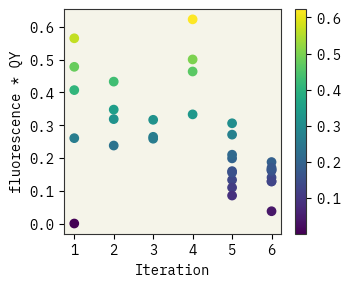

,Experiment,prompt,prediction,completion,peak1,peak2,area1,area2,QY,x,y
0,M1-R1,Stock nanoplatelets have dimensions 46.3494 nm...,0.19200,4.782817e-01,512.0,711.0,0.008152,9.132019e-01,0.523742,1,4.782817e-01
1,M1-R2,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,3.966778e-08,511.0,550.0,1.000000,3.568610e-08,1.111575,1,3.966778e-08
2,M1-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.08000,2.605435e-01,510.0,623.0,0.706617,2.907295e-01,0.896172,1,2.605435e-01
3,M1-R4,Stock nanoplatelets have dimensions 36.9235 nm...,0.04000,5.653835e-01,510.0,675.0,0.105641,8.775390e-01,0.644283,1,5.653835e-01
4,M1-R5,Stock nanoplatelets have dimensions 36.9235 nm...,0.08600,4.072398e-01,511.0,654.0,0.403294,5.915099e-01,0.688475,1,4.072398e-01
5,M2-R2,Stock nanoplatelets have dimensions 46.3494 nm...,0.13400,3.476881e-01,512.0,686.0,0.015672,9.566547e-01,0.363442,2,3.476881e-01
6,M2-R3,Stock nanoplatelets have dimensions 36.9235 nm...,0.15000,4.331438e-01,510.0,664.0,0.197992,7.958554e-01,0.544249,2,4.331438e-01
7,M2-R4,Stock nanoplatelets have dimensions 36.9 nm by...,0.13800,3.186709e-01,511.0,701.0,0.006012,9.501804e-01,0.335379,2,3.186709e-01
8,M2-R5,Stock nanoplatelets have dimensions 30.928 nm ...,0.15800,2.380121e-01,512.0,663.0,0.478363,4.826635e-01,0.493122,2,2.380121e-01
9,M3-R2,Stock nanoplatelets have dimensions 31.121 nm ...,0.17000,2.646450e-01,511.0,634.0,0.649612,3.455139e-01,0.765946,3,2.646450e-01


In [86]:
# plot completion results. But the experiments starting with M1 should be plotted with x=1, M2 with x=2, and M3 with x=3
fig, ax = plt.subplots()
pool_results['x'] = pool_results['Experiment'].apply(lambda x: int(x[1]))
pool_results['y'] = pool_results['completion']
plt.scatter(pool_results['x'], pool_results['y'], c=pool_results['completion'], cmap='viridis')
plt.xlabel('Iteration')
plt.ylabel('fluorescence * QY')
plt.xticks(np.arange(1, 7, 1))
plt.colorbar()
plt.show()

pool_results

In [87]:
for i in []:
    exp = pool_results.iloc[i]
    print(f"{exp['Experiment']}: {exp['prompt']}\nPredicted: {exp['prediction']}\nMeasured: {exp['completion']:.3f}\n")

# Creating bolift pool

In [67]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm):.3f} nm by {Dimension2(nm):.3f} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%):.3f}% recorded at 512 nm. {Nano_stock_vol(mL):.3f} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL):.3f} mL for each trial of doping. Silver acetate solution of {AgConc(M):.5f} M is made with {AgMass(mg):.3f} mg of silver acetate in {MeOH_vol(mL):.3f} mL of MeOH and {H2O_vol(mL):.3f} mL of water. {Doping(%):.3f} % Ag doping requires {AgSol(uL):.3f} uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C):.3f} oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

## Creating processed pool
Pool processed by Jorge's code (make_pool.ipynb)

In [68]:
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

# Data created by make_pool.ipynb
df = pd.read_csv('Data/pool_processed.csv')

pool_list = []
for i, row in df.iterrows():
    pool_list.append(prompt_template.format(**row.to_dict()))

with open('Data/pool_processed.txt', 'w') as output:
    output.write("prompt;completion\n")
    output.write('\n'.join(pool_list))

# pool = bolift.Pool(pool_list)
# cloudpickle.dump(pool, open('Data/pool_processed.pkl', 'wb'))

File not available: Data/proposed_trials/NLP2/M3-R1_corrected.txt
File not available: Data/proposed_trials/NLP2/M3-R4_corrected.txt


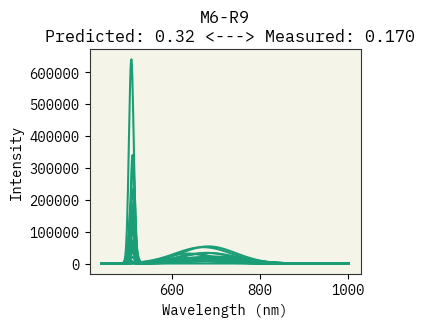

In [ ]:
df = pd.read_csv('Data/processed_data.csv')

import re
def extract_values(prompt):
    #TODO: Fix this regex to match the variance in the prompt
    pattern = (
        r"dimensions\s+(?P<Dimension1_nm>\d+\.\d+)\s*nm\s+by\s+(?P<Dimension2_nm>\d+\.\d+)\s*nm.*?"
        r"optical\s+density\s+of\s+100x\s+hexanes\s+dilution\s+of\s+stock\s+is\s+(?P<Dilution_percent>\d+\.\d+)%.*?"
        r"(?P<Nano_stock_vol_mL>\d+\.\d+)\s*mL\s+nanoplatelets\s+stock\s+is\s+diluted\s+7x\s+by\s+hexanes\s+using\s+(?P<Diluted_vol_mL>\d+\.\d+)\s*mL.*?"
        r"Silver\s+acetate\s+solution\s+of\s+(?P<AgConc_M>\d+\.\d+(?:e[+-]?\d+)?)\s*M.*?"
        r"(?P<AgMass_mg>\d+\.\d+)\s*mg\s+of\s+silver\s+acetate.*?"
        r"in\s+(?P<MeOH_vol_mL>\d+\.\d+)\s*mL\s+of\s+MeOH\s+and\s+(?P<H2O_vol_mL>\d+\.\d+)\s*mL\s+of\s+water.*?"
        r"(?P<Doping_percent>\d+\.\d+)\s*%\s+Ag\s+doping\s+requires\s+(?P<AgSol_uL>\d+\.\d+)\s*uL.*?"
        r"for\s+(?P<Time_min>\d+\.\d+|\d+)\s+minutes\s+at\s+(?P<Temperature_C>-?\d+\.\d+|\d+)\s*oC"
    )

    match = re.search(pattern, prompt, re.IGNORECASE)

    if match:
        return {
            key: float(value) if '.' in value else int(value)
            for key, value in match.groupdict().items()
        }
    return {}

for r in BO_NLP.keys():
    if not os.path.exists(f"Data/proposed_trials/NLP/{r}_corrected.txt"):
        print(f"File not available: Data/proposed_trials/NLP/{r}_corrected.txt")
        continue
    if not os.path.exists(f"Data/proposed_trials/NLP/{r}.csv"):
        print(f"File not available: Data/proposed_trials/NLP/{r}.csv")
        continue
    
    with open(f"Data/proposed_trials/NLP/{r}_corrected.txt", "r", encoding='utf-8-sig') as fl_data:
        with open(f"Data/proposed_trials/NLP/{r}.csv", "r", encoding='utf-8-sig') as abs_data:
            prompt = BO_NLP[r]
            is_val_data = False
            if r.startswith('M5') or r.startswith('M6'):
                is_val_data = True
            peak1, peak2, area1, area2, qy, completion, fl_data, abs_data = process_input(fl_data, abs_data, is_val_data = is_val_data)
            # variables = extract_variables(prompt)
            variables = {}
            prompts.append(prompt)
            labels_peak1.append(peak1)
            labels_peak2.append(peak2)
            labels_auc1.append(area1)
            labels_auc2.append(area2)
            labels_qy.append(qy)
            labels_f.append(completion)

    new_entry = pd.DataFrame({
        "Experiment": [r],
        'Peak1': [peak1], 
        'Peak2': [peak2], 
        'Area1': [area1], 
        'Area2': [area2],
        'QY': [qy],
        'Fl_Wavelengths': [str(fl_data[0])],
        'Fluorescence': [str(fl_data[1])],
        'Fluorescence_norm': [str(fl_data[2])],
        'Abs_Wavelengths': [str(abs_data[0])],
        'Absorbance': [str(abs_data[1])],
        'Absorbance_norm': [str(abs_data[2])]
    })
    df = pd.concat([df, new_entry], ignore_index=True)


df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

for r in BO_NLP.keys():
    if r in ["M1-R1", "M1-R3"]:
        continue
    try:
        sample = df[df['Experiment'] == r].iloc[0]
    except:
        continue
    results = pool_results[pool_results['Experiment'] == r].iloc[0]
    w = [float(a) for a in sample['Fl_Wavelengths'][1:-1].split(',')]
    i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]
    # w = [float(a) for a in sample['Abs_Wavelengths'][1:-1].split(',')]
    # i = [float(a) for a in sample['Absorbance'][1:-1].split(',')]

    plt.plot(w, i, color="C0")
    plt.title(f"{r}\n Predicted: {results['prediction']} <---> Measured: {results['completion']:.3f}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    # plt.ylabel("Absorbance")
plt.show()

In [91]:
df['f'] = df['Area2'] * df['QY']
df[['Peak1', "Peak2", "Area1", "Area2", "QY", "f"]].describe()

,Peak1,Peak2,Area1,Area2,QY,f
count,90.000000,90.000000,90.000000,9.000000e+01,90.000000,90.000000
mean,511.622222,641.855556,0.471453,5.178567e-01,0.192410,0.098523
std,4.793670,32.759101,0.315472,3.042824e-01,0.389973,0.193205
min,491.000000,550.000000,0.005083,3.568610e-08,-1.000000,-0.510526
25%,510.000000,623.000000,0.150953,2.689840e-01,0.098222,0.033908
50%,511.000000,632.500000,0.515507,4.811589e-01,0.191506,0.070175
75%,513.000000,663.750000,0.729617,8.445880e-01,0.361654,0.162590
max,549.000000,711.000000,1.000000,9.687314e-01,1.111575,0.623198


In [93]:
df.keys()

Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
       'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
       'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)',
       'Experiment', 'Peak1', 'Peak2', 'Area1', 'Area2', 'QY',
       'Fl_Wavelengths', 'Fluorescence', 'Fluorescence_norm',
       'Abs_Wavelengths', 'Absorbance', 'Absorbance_norm', 'f'],
      dtype='object')

## Create processed pool from Original Dataset with CEI_x and CEI_y



In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
# df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-3]
CIE = df.keys()[-2:]
labels = labels.append(CIE)
features, labels

(Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
        'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
        'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
       dtype='object'),
 Index(['Peak1', 'Peak2', 'Area1', 'Area2', 'Pre-QY', 'QY', 'QY_peak1',
        'QY_peak2', 'Fl_Wavelengths', 'Fluorescence', 'Fluorescence_norm',
        'Abs_Wavelengths', 'Absorbance', 'CIE_x', 'CIE_y'],
       dtype='object'))

In [7]:
prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512 nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."


df['Prompt'] = df.apply(lambda row: prompt_template.format(**row), axis=1)
df['f'] = df['QY'] * df['Area2']
df.head()

,Dimension1(nm),Dimension2(nm),Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),...,Fl_Wavelengths,Fluorescence,Fluorescence_norm,Abs_Wavelengths,Absorbance,Absorbance_norm,CIE_x,CIE_y,Prompt,f
0,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5,2,1.25,...,"[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...","[5.3922465999834595, 5.551067438955388, 5.7155...","[0.0010700124103508776, 0.0011015280811517685,...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.43802025, 0.4338412, 0.42938566666666667, 0...","[1.0, 0.9904592310515324, 0.9802872507987169, ...",0.521398,0.447538,Stock nanoplatelets have dimensions 18.8 nm by...,3.074970e-01
1,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5,2,2.50,...,"[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...","[0.05875342277612322, 0.061531410939200504, 0....","[2.1105257504146727e-05, 2.2103159460405937e-0...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.43802025, 0.4338412, 0.42938566666666667, 0...","[1.0, 0.9904592310515324, 0.9802872507987169, ...",0.650174,0.348096,Stock nanoplatelets have dimensions 18.8 nm by...,2.307426e-01
2,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5,2,5.00,...,"[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...","[0.16726935860227754, 0.17430678840129743, 0.1...","[5.7619824046038625e-05, 6.00440305483188e-05,...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.43802025, 0.4338412, 0.42938566666666667, 0...","[1.0, 0.9904592310515324, 0.9802872507987169, ...",0.639103,0.358419,Stock nanoplatelets have dimensions 18.8 nm by...,2.346841e-01
3,18.8,14.04,0.175,0.25,1.75,0.0060,7.8,5,2,10.00,...,"[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...","[0.0059593828942451415, 0.006355854469534446, ...","[5.1227292593135085e-06, 5.463539134306094e-06...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.43802025, 0.4338412, 0.42938566666666667, 0...","[1.0, 0.9904592310515324, 0.9802872507987169, ...",0.658767,0.339308,Stock nanoplatelets have dimensions 18.8 nm by...,8.388796e-02
4,18.8,14.04,0.175,0.25,1.75,0.0007,3.5,20,8,0.25,...,"[441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447...","[1.9618019074826825e-16, 6.15887754421026e-16,...","[5.600871903107058e-22, 1.7583367648116504e-21...","[300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306...","[0.43802025, 0.4338412, 0.42938566666666667, 0...","[1.0, 0.9904592310515324, 0.9802872507987169, ...",0.041857,0.777612,Stock nanoplatelets have dimensions 18.8 nm by...,4.928815e-08


In [5]:
#save the data as procedures_CIE.tsv but only prompts and CIE vals
df[['Prompt', 'CIE_x', 'CIE_y']].to_csv("Data/procedures_CIE.tsv", sep='\t', index=False)